In [1]:
import numpy as np
import pandas as pd
import random as ran
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [2]:
class User:
    def __init__(self, user_id,importance_features, not_sincerity=False):
        self.user_id = user_id
        self.importance_features = importance_features
        self.survey = pd.DataFrame(columns=['no','temp','hum', 'lux', 'score'])
        self.not_sincerity = not_sincerity
        
    def save_survey(self, no,temp, hum, lux ,score):
        self.survey = self.survey.append({
            "no": no,
            "temp": temp,
            "hum": hum,
            "lux": lux,
            "score": score
        }, ignore_index=True)
    
    def score(self, temp, hum, lux):
        _score = np.array([0,0,0])
        
        if len(self.importance_features) == 0:
            if self.not_sincerity:
                for idx in range(0, len(_score)):
                    _score[idx] = 20
            else:
                one_line = ran.randrange(0, 2)
                if one_line == 0:
                    s = ran.randrange(5, 21, 5)
                    for idx in range(0, len(_score)):
                        _score[idx] = s
                else:
                    for idx in range(0, len(_score)):
                        _score[idx] = ran.randrange(5, 21)
        else:
            if 'temp' in self.importance_features:
                if (temp >= 18) & (temp <= 20):
                    _score[0] = 20
                else:
                    err = 0
                    if temp <= 18:
                        err = 18 - temp
                    else:
                        err = temp - 20
                    _score[0] = 20 - round(err / 2)
            else:
                _score[0] = ran.randrange(17, 21)
                    

            if 'hum' in self.importance_features:
                if (hum >= 40) & (hum <= 60):
                    _score[1] = 20
                else:
                    err = 0
                    if hum <= 40:
                        err = 40 - hum
                    else:
                        err = hum - 60
                    _score[1] = 20 - round(err / 5)
            else:
                _score[1] = ran.randrange(17, 21)


            if 'lux' in self.importance_features:
                if (lux >= 700) & (lux <= 1500):
                    _score[2] = 20
                else:
                    err = 0
                    if temp < 700:
                        err = 700 - lux
                    else:
                        err = lux - 1500
                    _score[2] = 20 - round(err / 100)
            else:
                _score[2] = ran.randrange(17, 21)

        return _score.sum()
    
def generate_features():
    features = ['temp', 'hum', 'lux']
    imp_features = list()
    for f in features:
        is_in = ran.randrange(0,2)
        if is_in == 0:
            imp_features.append(f)
    
    if len(imp_features) == 0:
        is_in = ran.randrange(0, 3)
        imp_features.append(features[is_in])
        
    return imp_features            

In [3]:
# 성실 참여자 50명 생성
users = list()
for user_id in range(0, 50):
    user = User(user_id, generate_features())
    users.append(user)
    
# 불성실 참여자 30명 생성
for user_id in range(50, 80):
    user = User(user_id, [])
    users.append(user)
    
# 매우불성실 참여자 20명 생성
for user_id in range(80, 100):
    user = User(user_id, [], True)
    users.append(user)
    
now = dt.datetime.now()

for days in range(0, 540):
    now_after = now + dt.timedelta(days=days)
    str_after = dt.datetime.strftime(now_after, '%Y-%m-%d')
    
    # 온도 10~32
    ran_temp = ran.randrange(10, 33)
    
    # 습도 30 ~ 80
    ran_hum = ran.randrange(30, 81)
    
    # 조도 200 ~ 1900 (100 단위)
    ran_lux = ran.randrange(200, 1901, 100)
    
    for user in users:
        _s = user.score(ran_temp,
                       ran_hum,
                       ran_lux)
        user.save_survey(
            days,
            ran_temp,
            ran_hum,
            ran_lux,
            _s
        )

In [4]:
user = users[0]
print("user id : {} / 중요 특징 : {}"
      .format(user.user_id, user.importance_features))

df = user.survey
df

user id : 0 / 중요 특징 : ['temp', 'lux']


,no,temp,hum,lux,score
0,0,32,41,900,52
1,1,21,38,1600,69
2,2,29,33,400,50
3,3,17,56,1600,69
4,4,19,66,1500,58
...,...,...,...,...,...
535,535,26,79,1200,57
536,536,28,32,1400,53
537,537,24,77,1700,68
538,538,20,67,500,57


In [5]:
features = np.array(['no', 'temp', 'hum', 'lux'])

X = df[features].to_numpy().copy()
y = df[['score']].to_numpy().copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [6]:
RFModel = RandomForestRegressor(n_estimators=20,
                                oob_score=False,
                                random_state=531)

In [7]:
RFModel.fit(X_train, y_train.ravel())

RandomForestRegressor(n_estimators=20, random_state=531)

In [8]:
prediction = RFModel.predict(X_test)
mse = mean_squared_error(y_test,prediction)
print("MSE: {}".format(mse))

MSE: 2.357407407407409


In [9]:
feature_importance = RFModel.feature_importances_

In [10]:
print(feature_importance)

[0.01515577 0.11138013 0.01513972 0.85832439]


In [11]:
feature_importance = feature_importance / feature_importance.max()
print(feature_importance)

[0.01765739 0.12976461 0.01763869 1.        ]


In [12]:
sorted_idx = np.argsort(feature_importance)
print(sorted_idx[::-1])

[3 1 0 2]


In [13]:
bar_pos = np.arange(sorted_idx.shape[0]) + .5
bar_pos

array([0.5, 1.5, 2.5, 3.5])

In [14]:
feature_importance[sorted_idx]

array([0.01763869, 0.01765739, 0.12976461, 1.        ])

In [15]:
features[sorted_idx[::-1]]

array(['lux', 'temp', 'no', 'hum'], dtype='<U4')

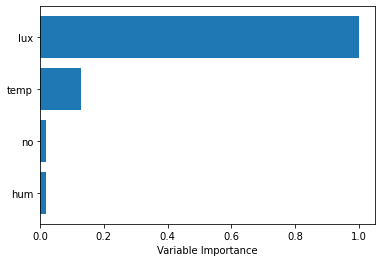

In [16]:
plt.barh(bar_pos, feature_importance[sorted_idx], align='center')
plt.yticks(bar_pos, features[sorted_idx])
plt.xlabel("Variable Importance")
plt.show()

# 실제 특징과 주요 특징 비교

In [67]:
# 정규화

user = users[0]
user.survey[['temp']].to_numpy().copy() / user.survey[['temp']].to_numpy().max()



array([[1.0],
       [0.65625],
       [0.90625],
       [0.53125],
       [0.59375],
       [0.625],
       [0.59375],
       [0.875],
       [0.34375],
       [0.4375],
       [0.34375],
       [0.71875],
       [0.78125],
       [0.375],
       [0.90625],
       [0.65625],
       [0.9375],
       [0.78125],
       [0.4375],
       [0.875],
       [0.96875],
       [0.8125],
       [0.90625],
       [0.40625],
       [0.59375],
       [0.4375],
       [0.90625],
       [0.6875],
       [0.90625],
       [0.375],
       [1.0],
       [0.53125],
       [0.375],
       [0.875],
       [0.5625],
       [0.34375],
       [0.625],
       [0.46875],
       [0.59375],
       [0.5625],
       [0.96875],
       [0.875],
       [0.375],
       [0.71875],
       [0.84375],
       [0.34375],
       [0.78125],
       [0.34375],
       [0.5625],
       [0.8125],
       [0.90625],
       [0.5625],
       [0.34375],
       [0.65625],
       [0.375],
       [0.90625],
       [0.4375],
       [0.59375]

In [71]:
user.survey[['temp']].to_numpy().argmax()

0

In [42]:
features = np.array(['no', 'temp', 'hum', 'lux'])
_record = pd.DataFrame(columns=['user id',
                                'imp features', 
                                'RF imp features', 
                                'mse'])

for user in users:
    df = user.survey
    X = df[features].to_numpy().copy()
    y = df[['score']].to_numpy().copy()
    RF_imp_features = None
    
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

    RFModel = RandomForestRegressor(n_estimators=100,
                                    max_features=3,
                                oob_score=False,random_state=531)
    RFModel.fit(X_train, y_train.ravel())
    prediction = RFModel.predict(X_test)
    
    mse = mean_squared_error(y_test,prediction)
    
    feature_importance = RFModel.feature_importances_
    if len(set(feature_importance)) == 1:
        RF_imp_features = []
    else:
        feature_importance = feature_importance / feature_importance.max()
    
    sorted_idx = np.argsort(feature_importance)
    bar_pos = np.arange(sorted_idx.shape[0]) + .5
    
    _features = features[sorted_idx[::-1]]
    user_id = user.user_id
    user_imp_features = user.importance_features
    
    imp_length = len(user_imp_features)
    
    if RF_imp_features == None:
        if imp_length == 0:
            RF_imp_features = [_features[0]]
        else:
            RF_imp_features = _features[:imp_length]
        
    _imp_features = RF_imp_features
    imp_features = list()
    
    for _ in ['no', 'temp', 'hum', 'lux']:
        if _ in _imp_features:
            imp_features.append(_)

    _record = _record.append({
        "user id": user_id,
        "mse": mse,
        "imp features": ",".join(user_imp_features),
        "RF imp features": ",".join(imp_features)
    }, ignore_index=True)

In [49]:
part_user = _record[:50].copy()
# part_user[part_user['imp features'] == part_user['RF imp features']]

In [50]:
part_user

,user id,imp features,RF imp features,mse
0,0,"temp,lux","temp,lux",1.721064
1,1,"temp,lux","temp,lux",1.698840
2,2,"temp,hum","temp,hum",1.865211
3,3,"temp,hum,lux","temp,hum,lux",0.452956
4,4,"temp,hum","temp,hum",1.525244
5,5,"temp,hum,lux","temp,hum,lux",0.439131
6,6,"temp,hum,lux","temp,hum,lux",0.519036
7,7,hum,hum,2.878930
8,8,"temp,hum","temp,hum",1.463516
9,9,lux,lux,2.858982


In [51]:
_analysis = pd.DataFrame(columns=['총 참여자 수','중요 특징 비교', '평균 mse'])

user_cnt = len(part_user)
compare_cnt = part_user[part_user['imp features'] == part_user['RF imp features']].count()['imp features']
mean_mse = part_user[part_user['imp features'] == part_user['RF imp features']]['mse'].mean()

_analysis = _analysis.append({
    "총 참여자 수": str(user_cnt),
    "중요 특징 비교": str(compare_cnt),
    "평균 mse": mean_mse
}, ignore_index=True)

_analysis

,총 참여자 수,중요 특징 비교,평균 mse
0,50,50,1.930628


In [21]:
unpart_user = _record[50:].copy()
unpart_user

,user id,imp features,RF imp features,mse
50,50,,no,151.687176
51,51,,no,173.559838
52,52,,no,233.090602
53,53,,no,182.370162
54,54,,no,165.504074
55,55,,no,212.499051
56,56,,no,212.893032
57,57,,no,148.746389
58,58,,no,178.271366
59,59,,no,218.319074


In [22]:
_analysis = pd.DataFrame(columns=['총 참여자 수','중요 특징 비교', '평균 mse'])

user_cnt = len(unpart_user)
compare_cnt = unpart_user[unpart_user['imp features'] == unpart_user['RF imp features']].count()['imp features']
mean_mse = unpart_user[unpart_user['imp features'] == unpart_user['RF imp features']]['mse'].mean()

_analysis = _analysis.append({
    "총 참여자 수": str(user_cnt),
    "중요 특징 비교": str(compare_cnt),
    "평균 mse": mean_mse
}, ignore_index=True)

_analysis

,총 참여자 수,중요 특징 비교,평균 mse
0,50,20,0.0


In [23]:
user = users[99]

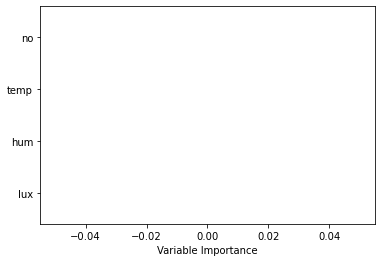

In [24]:
df = user.survey
X = df[features].to_numpy().copy()
y = df[['score']].to_numpy().copy()

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

RFModel = RandomForestRegressor(n_estimators=20,
                            oob_score=False,random_state=531)
RFModel.fit(X_train, y_train.ravel())
prediction = RFModel.predict(X_test)

mse = mean_squared_error(y_test,prediction)

feature_importance = RFModel.feature_importances_
if len(set(feature_importance)) == 1:
    feature_importance = RFModel.feature_importances_
else:    
    feature_importance = feature_importance / feature_importance.max()

sorted_idx = np.argsort(feature_importance)
bar_pos = np.arange(sorted_idx.shape[0]) + .5

_features = features[sorted_idx[::-1]]

plt.barh(bar_pos, feature_importance, align='center')
plt.yticks(bar_pos, _features)
plt.xlabel("Variable Importance")
plt.show()

In [25]:
np.argsort(feature_importance)

array([0, 1, 2, 3])

In [26]:
_record.groupby("RF imp features").count()['imp features']

RF imp features
                20
hum              4
hum,lux          8
lux              9
no              30
no,temp,lux      1
temp             4
temp,hum         9
temp,hum,lux     5
temp,lux        10
Name: imp features, dtype: int64

In [ ]:
# 위의 내용 적고, 참여도가 높다고 판단된 사용자들의 평균치로 RF Model 훈련
# 가장 많은 선호도를 가진 특징이 RF Model 중요 특징으로 나타날 것 인가?

In [52]:
anal_user = part_user.copy()

In [53]:
anal_user['temp'] = part_user['imp features'].map(lambda x: "temp" in x)
anal_user['hum'] = part_user['imp features'].map(lambda x: "hum" in x)
anal_user['lux'] = part_user['imp features'].map(lambda x: "lux" in x)

In [54]:
apt_anal = pd.DataFrame()
apt_anal['온도'] = [anal_user[anal_user['temp'] == True].count().values[0]]
apt_anal['습도'] = [anal_user[anal_user['hum'] == True].count().values[1]]
apt_anal['조도'] = [anal_user[anal_user['lux'] == True].count().values[1]]

apt_anal

,온도,습도,조도
0,29,27,33


In [55]:
part_user.groupby('imp features').count().sort_values(by=['user id'], ascending=False)

,user id,RF imp features,mse
imp features,,,
"temp,lux",10,10,10
lux,9,9,9
"temp,hum",9,9,9
"hum,lux",8,8,8
"temp,hum,lux",6,6,6
hum,4,4,4
temp,4,4,4


In [56]:
survey_mean = np.array([])
feature_tmp = np.array([])

for _ in users[0].survey.values:
    feature_tmp = np.append(feature_tmp,_[1:4])
feature_tmp = feature_tmp.reshape(-1, 3)

for survey_no in range(0,540):
    _tmp = np.array([])
    for user_no in range(0, 100):
        _tmp = np.append(_tmp, users[user_no].survey.loc[survey_no]['score'])
    survey_mean = np.append(survey_mean,_tmp.mean())

In [57]:
X_train, X_test, y_train, y_test = train_test_split(feature_tmp,survey_mean, test_size=0.2)

[0.1189628 0.0998645 0.7811727]
[0.15228745 0.12783921 1.        ]
0.8374478141005492


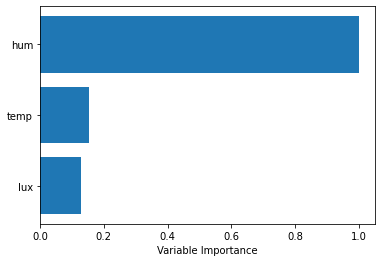

In [60]:
features = np.array(['temp', 'hum', 'lux'])

RFModel = RandomForestRegressor(n_estimators=100,
                                max_features=3,
                            oob_score=False,random_state=531)
RFModel.fit(X_train, y_train.ravel())
prediction = RFModel.predict(X_test)

mse = mean_squared_error(y_test,prediction)

feature_importance = RFModel.feature_importances_
if len(set(feature_importance)) == 1:
    feature_importance = RFModel.feature_importances_
else:    
    feature_importance = feature_importance / feature_importance.max()

print(RFModel.feature_importances_)
print(feature_importance)
sorted_idx = np.argsort(feature_importance)
bar_pos = np.arange(sorted_idx.shape[0]) + .5

_features = features[sorted_idx[::-1]]

print(mse)
plt.barh(bar_pos, feature_importance[sorted_idx], align='center')
plt.yticks(bar_pos, _features)
plt.xlabel("Variable Importance")
plt.show()